# Подготовка к анализу

## Импорты

In [35]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
from wordcloud import WordCloud

## Загрузка ресурсов NLTK

In [2]:
nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)

True

## Загрузка очищенных отзывов

In [3]:
input_file = "../data/dataset/geo_reviews_cleaned.json"
with open(input_file, "r", encoding="utf-8") as f:
    reviews = json.load(f)

## Преобразование в DataFrame

In [4]:
reviews_df = pd.DataFrame(reviews)

# EDA

## Расчет базовых статистик для отзывов

In [14]:
def calculate_basic_stats(reviews):
    word_counts = [len(review["text"].split()) for review in reviews]
    stats = {
        "avg_words": np.mean(word_counts),
        "std_words": np.std(word_counts),
        "min_words": np.min(word_counts),
        "max_words": np.max(word_counts),
        "median_words": np.median(word_counts),
    }
    return stats

basic_stats = calculate_basic_stats(reviews)
print("Базовая статистика:")
print(f"Среднее количество слов: {basic_stats['avg_words']:.2f}")
print(f"Стандартное отклонение: {basic_stats['std_words']:.2f}")
print(f"Минимальное количество слов: {basic_stats['min_words']}")
print(f"Максимальное количество слов: {basic_stats['max_words']}")
print(f"Медиана количества слов: {basic_stats['median_words']}")

Базовая статистика:
Среднее количество слов: 43.79
Стандартное отклонение: 44.66
Минимальное количество слов: 1
Максимальное количество слов: 3017
Медиана количества слов: 30.0


## Получение топ-10 рубрик по количеству отзывов

In [19]:
def get_top_rubrics(reviews_df, n=10):
    rubrics = reviews_df["rubrics"].apply(lambda x: x.split(";")).explode()
    rubrics = rubrics.apply(lambda x: x.strip())
    top_rubrics = rubrics.value_counts().head(n).index.tolist()
    return top_rubrics

total_reviews = len(reviews_df)
top_rubrics = get_top_rubrics(reviews_df)
for i, rubric in enumerate(top_rubrics, start=1):
        rubric_count = reviews_df["rubrics"].apply(lambda x: rubric in x).sum()
        percentage = (rubric_count / total_reviews) * 100
        print(f"{i}. {rubric} - {rubric_count} отзывов ({percentage:.2f}%)")

1. кафе - 59184 отзывов (11.87%)
2. ресторан - 56684 отзывов (11.37%)
3. гостиница - 43366 отзывов (8.70%)
4. магазин продуктов - 21308 отзывов (4.27%)
5. супермаркет - 19709 отзывов (3.95%)
6. бар, паб - 19161 отзывов (3.84%)
7. салон красоты - 17796 отзывов (3.57%)
8. быстрое питание - 16785 отзывов (3.37%)
9. доставка еды и обедов - 14361 отзывов (2.88%)
10. ногтевая студия - 11532 отзывов (2.31%)


## Построение графика распределения рейтингов по рубрикам

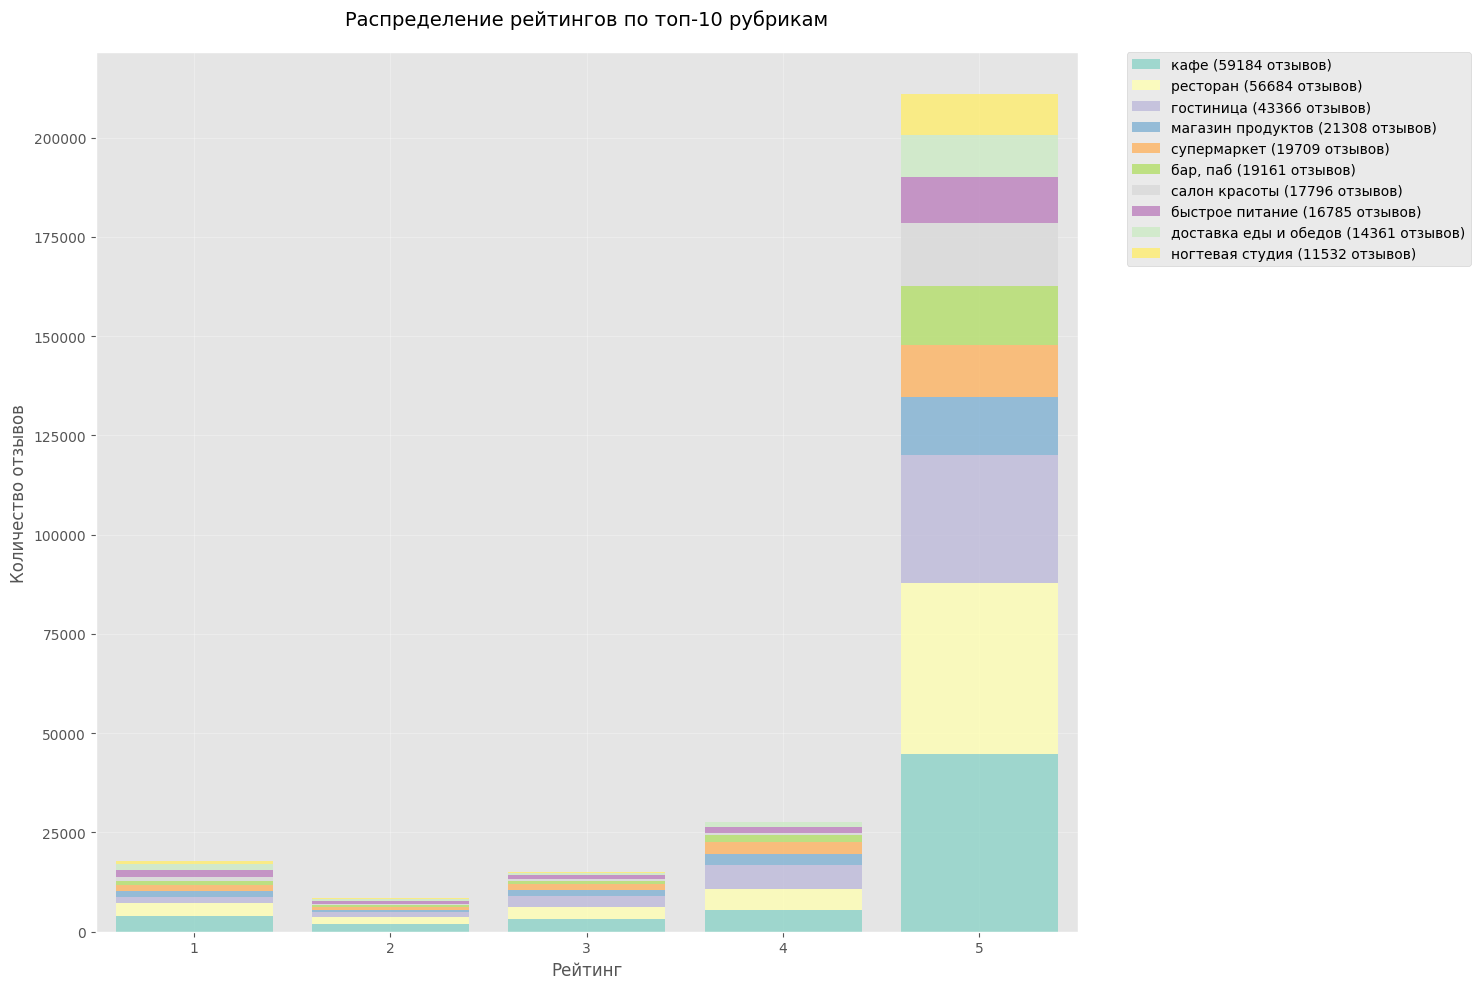

In [69]:
def plot_ratings_distribution(reviews_df, top_rubrics):
    plt.figure(figsize=(15, 10))
    ratings_data = []
    for rubric in top_rubrics:
        rubric_reviews = reviews_df[reviews_df["rubrics"].apply(lambda x: rubric in x)]
        ratings = rubric_reviews["rating"].value_counts().sort_index()
        for rating, count in ratings.items():
            ratings_data.append({"rubric": rubric, "rating": rating, "count": count})

    df = pd.DataFrame(ratings_data)
    plt.style.use("ggplot")
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_rubrics)))

    bottom = np.zeros(len(df["rating"].unique()))
    legend_labels = []
    for rubric, color in zip(top_rubrics, colors):
        total_reviews = len(reviews_df[reviews_df["rubrics"].apply(lambda x: rubric in x)])
        legend_labels.append(f"{rubric} ({total_reviews} отзывов)")
        mask = df["rubric"] == rubric
        bar = plt.bar(
            df[mask]["rating"],
            df[mask]["count"],
            bottom=bottom[df[mask]["rating"].astype(int) - 1],
            color=color,
            label=legend_labels[-1],
            alpha=0.8,
        )
        bottom += np.array(
            [
                df[(df["rubric"] == rubric) & (df["rating"] == i)]["count"].iloc[0]
                if len(df[(df["rubric"] == rubric) & (df["rating"] == i)]) > 0
                else 0
                for i in range(1, 6)
            ]
        )

    plt.grid(True, alpha=0.3)
    plt.title("Распределение рейтингов по топ-10 рубрикам", fontsize=14, pad=20)
    plt.xlabel("Рейтинг", fontsize=12)
    plt.ylabel("Количество отзывов", fontsize=12)
    plt.xticks(range(1, 6))
    plt.xlim(0.5, 5.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.tight_layout()
    plt.savefig('./img/ratings_distribution.png')
    plt.show()

plot_ratings_distribution(reviews_df, top_rubrics)

## Анализ распределения длин отзывов

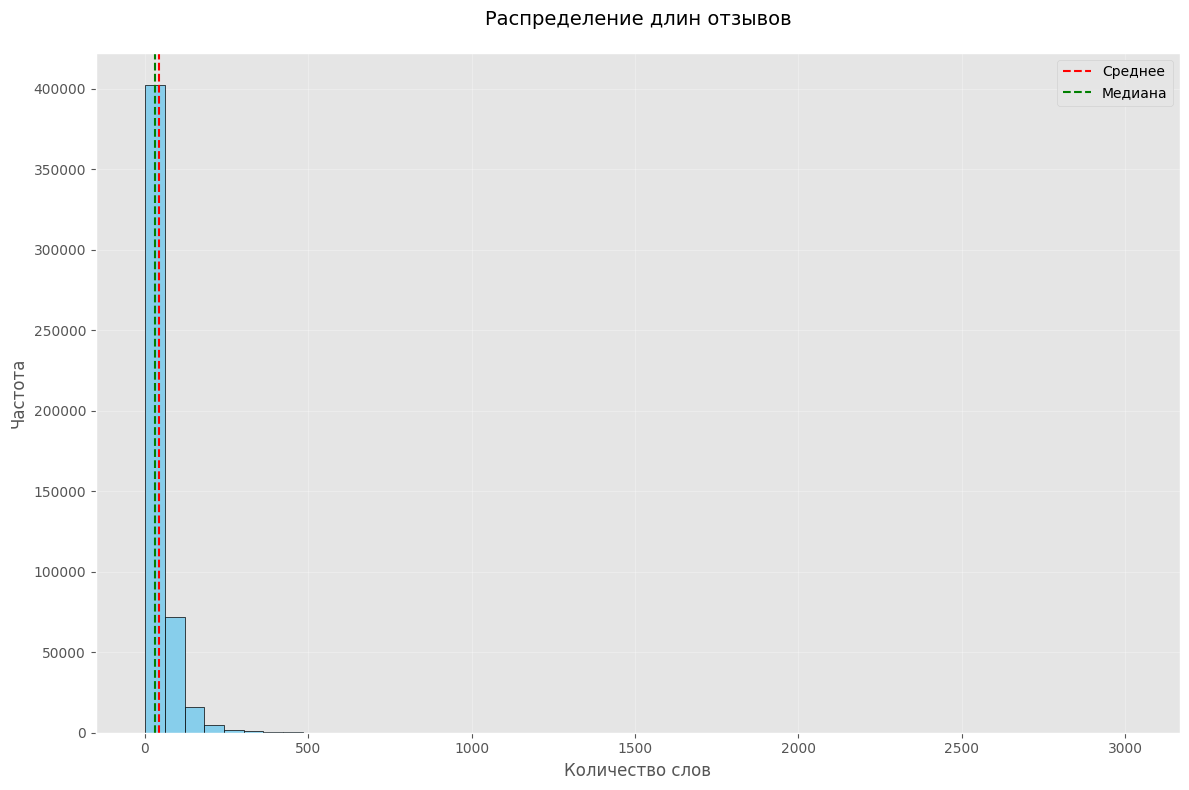

Статистика распределения длин:
Средняя длина: 43.79
Медиана длины: 30.00
Стандартное отклонение: 44.66
Минимальная длина: 1.0
Максимальная длина: 3017.0
25-й перцентиль: 20.00
75-й перцентиль: 52.00


In [70]:
def analyze_length_distribution(reviews):
    lengths = [len(review["text"].split()) for review in reviews]
    stats = {
        "mean": float(np.mean(lengths)),
        "median": float(np.median(lengths)),
        "std": float(np.std(lengths)),
        "min": float(np.min(lengths)),
        "max": float(np.max(lengths)),
        "percentile_25": float(np.percentile(lengths, 25)),
        "percentile_75": float(np.percentile(lengths, 75)),
    }

    plt.figure(figsize=(12, 8))
    plt.hist(lengths, bins=50, color="skyblue", edgecolor="black")
    plt.title("Распределение длин отзывов", fontsize=14, pad=20)
    plt.xlabel("Количество слов", fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axvline(stats["mean"], color="red", linestyle="--", label="Среднее")
    plt.axvline(stats["median"], color="green", linestyle="--", label="Медиана")
    plt.legend()
    plt.tight_layout()
    plt.savefig('./img/length_distribution.png')
    plt.show()

    return stats

length_stats = analyze_length_distribution(reviews)
print("Статистика распределения длин:")
print(f"Средняя длина: {length_stats['mean']:.2f}")
print(f"Медиана длины: {length_stats['median']:.2f}")
print(f"Стандартное отклонение: {length_stats['std']:.2f}")
print(f"Минимальная длина: {length_stats['min']}")
print(f"Максимальная длина: {length_stats['max']}")
print(f"25-й перцентиль: {length_stats['percentile_25']:.2f}")
print(f"75-й перцентиль: {length_stats['percentile_75']:.2f}")

## Извлечение ключевых слов из отзывов по рубрикам

In [25]:
def extract_keywords(reviews_df):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("russian"))
    custom_stops = {
        "это", "весь", "свой", "который", "также", "более", "менее", "очень", "просто",
        "только", "такой", "самый", "ещё", "где", "когда", "почему", "как", "что",
        "чем", "зачем", "сейчас", "тоже", "уже", "еще", "вот", "быть", "мой", "наш",
        "ваш", "их", "его", "её", "там", "здесь", "туда", "сюда", "куда", "где",
        "везде", "нигде", "потом", "теперь", "всегда", "никогда",
    }
    stop_words.update(custom_stops)

    def preprocess_text(text, lemmatizer, stop_words):
        lemmatized = [lemmatizer.lemmatize(word) for word in text.split()]
        lemmatized = [
            word.strip()
            for word in lemmatized
            if (
                word.strip()
                and word.strip() not in stop_words
                and len(word.strip()) > 2
                and not word.strip().isdigit()
            )
        ]
        return " ".join(lemmatized)

    reviews_by_rubric = defaultdict(list)
    for _, review in reviews_df.iterrows():
        rubrics = review["rubrics"].split(";")
        for rubric in rubrics:
            if rubric.strip():
                reviews_by_rubric[rubric.strip()].append(review)

    keywords = {}
    for rubric, reviews in tqdm(reviews_by_rubric.items(), desc="Извлечение ключевых слов", ncols=100):
        texts = [review["text"] for review in reviews if len(review["text"]) >= 10]
        if len(texts) < 2:
            continue

        processed_texts = [preprocess_text(text, lemmatizer, stop_words) for text in texts]
        processed_texts = [text for text in processed_texts if text.strip()]
        if len(processed_texts) < 2:
            continue

        vectorizer = TfidfVectorizer(
            max_features=1000,
            min_df=1,
            max_df=0.95,
            stop_words=list(stop_words),
            ngram_range=(1, 2),
            preprocessor=lambda x: preprocess_text(x, lemmatizer, stop_words),
        )
        vectorizer.fit(processed_texts)
        tfidf_matrix = vectorizer.transform(processed_texts)
        feature_names = vectorizer.get_feature_names_out()
        if len(feature_names) == 0:
            continue

        raw_frequencies = np.array(tfidf_matrix.tocsr().sum(axis=0)).flatten()
        word_scores = [
            (word, float(freq))
            for word, freq in zip(feature_names, raw_frequencies)
            if freq > 0
        ]
        if word_scores:
            max_score = max(score for _, score in word_scores)
            word_scores = [(word, score / max_score) for word, score in word_scores]
        word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
        keywords[rubric] = word_scores

    current_dir = os.getcwd()
    data_dir = os.path.join(current_dir, "..", "data")
    keywords_file = os.path.join(data_dir, "keywords.json")
    with open(keywords_file, "w", encoding="utf-8") as f:
        json.dump(
            {
                rubric: [[word, float(score)] for word, score in words]
                for rubric, words in keywords.items()
            },
            f,
            ensure_ascii=False,
            indent=2,
        )

    return keywords

keywords = extract_keywords(reviews_df)

Извлечение ключевых слов: 100%|█████████████████████████████████| 1370/1370 [11:50<00:00,  1.93it/s]


## Визуализация облака ключевых слов

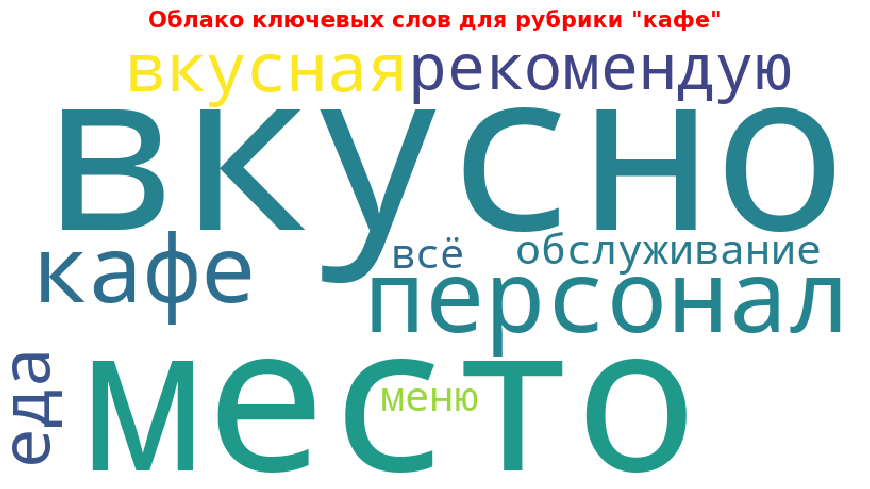

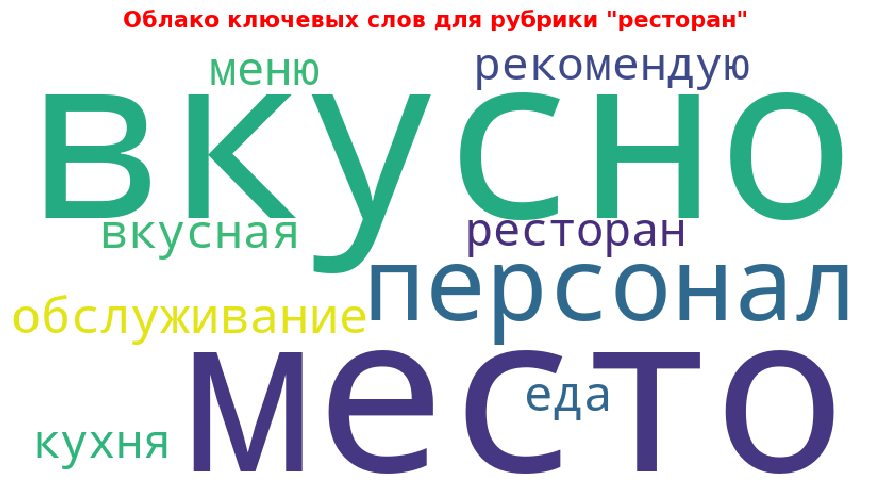

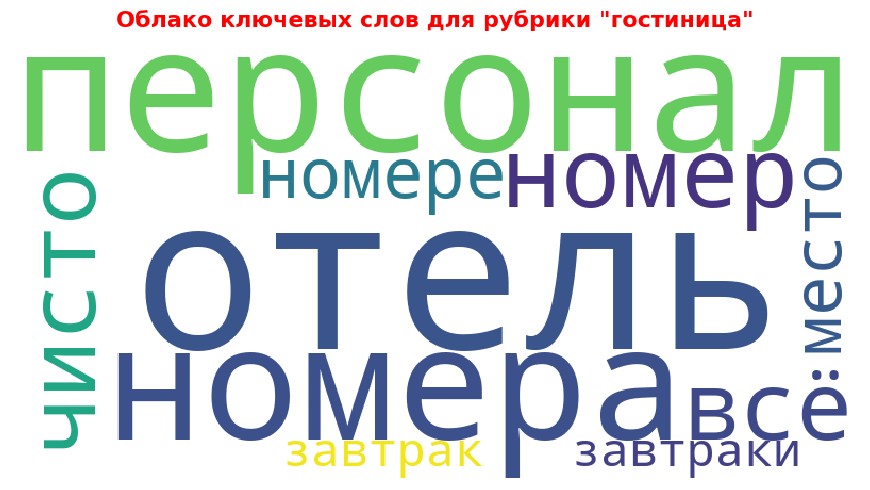

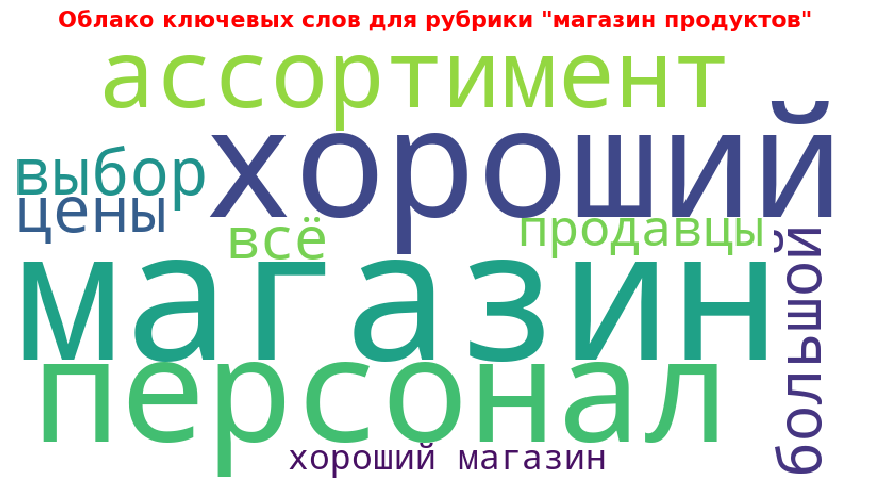

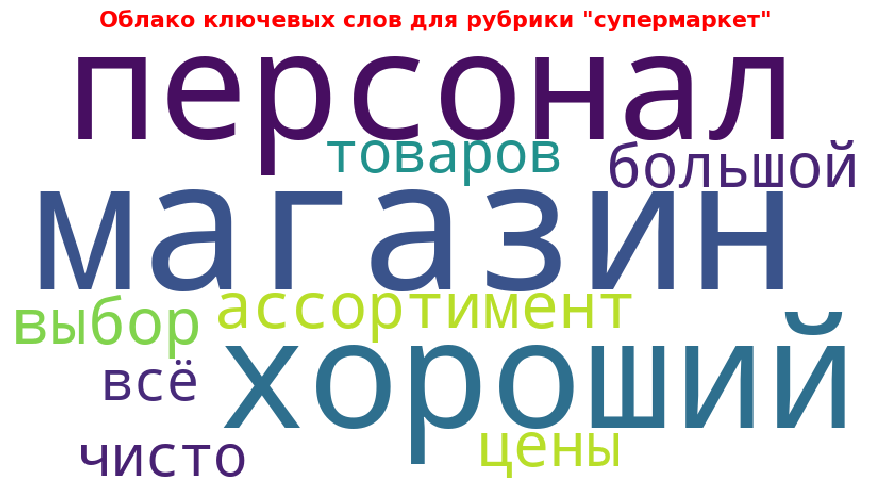

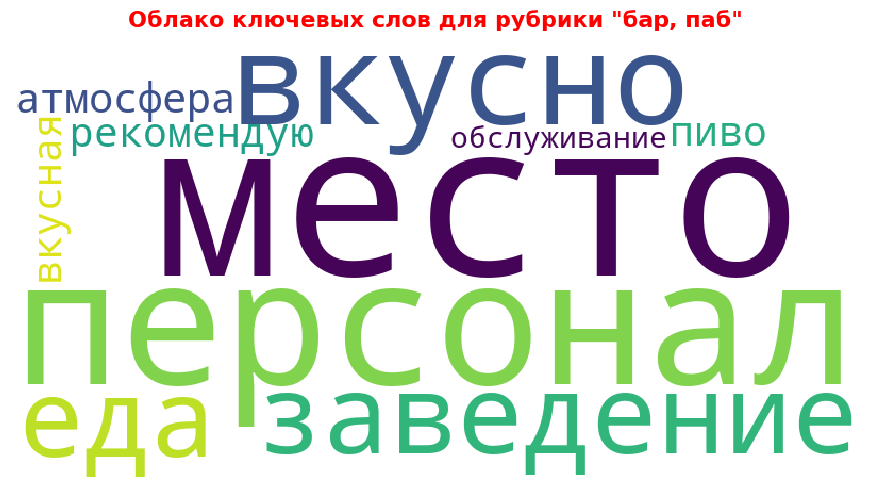

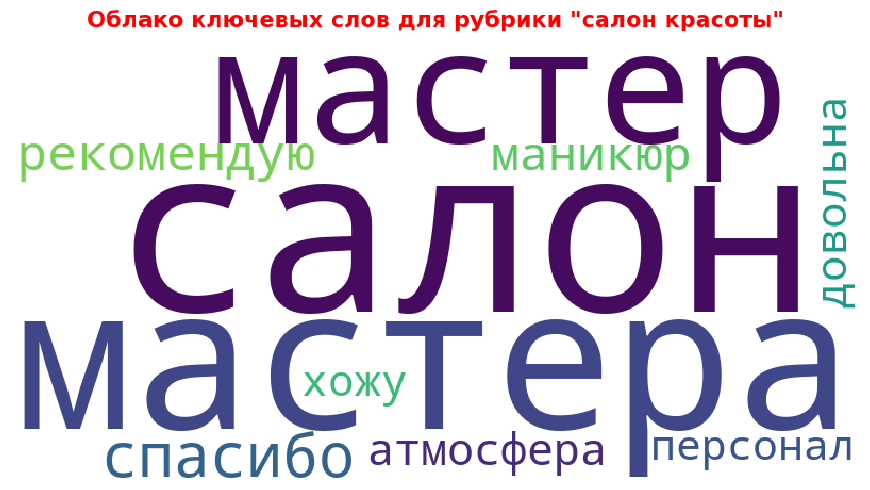

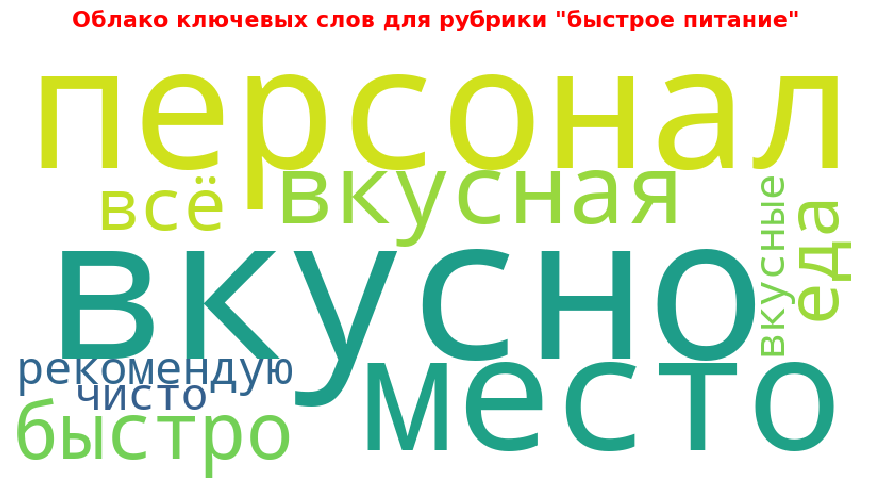

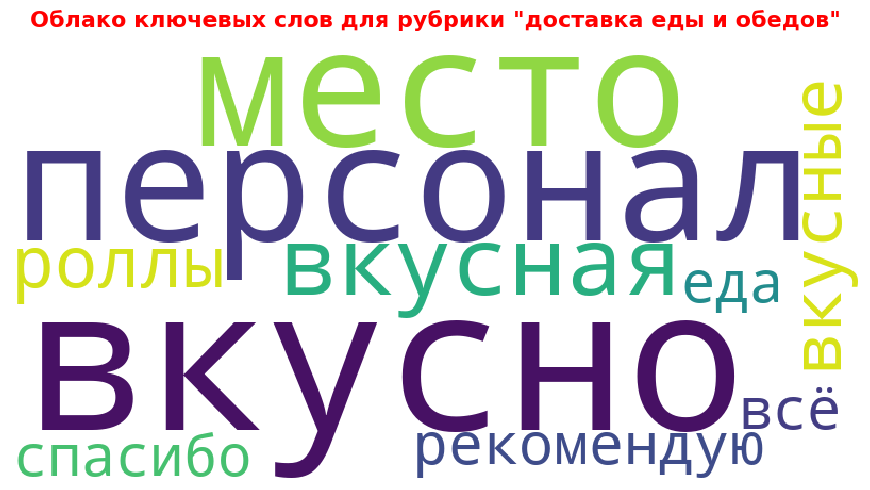

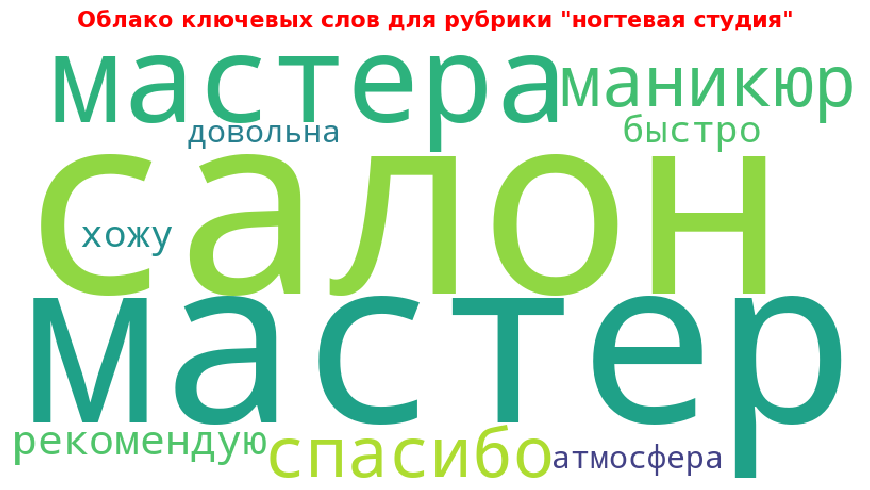

In [71]:
def plot_keywords_cloud(keywords, top_rubrics):
    for rubric in top_rubrics:
        if rubric in keywords:
            word_freq = {word: score for word, score in keywords[rubric]}
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='nearest')
            plt.axis('off')
            
            plt.title(
                f'Облако ключевых слов для рубрики "{rubric}"',
                fontsize=16, color='red', weight='bold', pad=20
                )            
            plt.tight_layout()
            plt.savefig(f'./img/wordcloud_{rubric}.png')
            plt.show()

plot_keywords_cloud(keywords, top_rubrics)